In [10]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os
from pathlib import Path
import pickle as pkl
import sys
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import csv
from sklearn.metrics import mean_squared_error, r2_score
import calendar

# working directory

In [ ]:
sitename = "BART_NEON"
# site_data_dir = Path(f"F:/NEON_gapfill/") # local
site_data_dir = Path("/home/jovyan") # binder working directory
model_dir = site_data_dir / "XGB_models"
model_dir.mkdir(exist_ok=True)
data_train_test_dir = site_data_dir / "FC_data_train_test"
sys.path.append(site_data_dir)
os.chdir(site_data_dir)
cwd = os.getcwd()
print("Current working directory: ", cwd)
learning_curve_dir = site_data_dir / "learning_curve"
learning_curve_dir.mkdir(exist_ok=True)
test_performance_dir = site_data_dir / "test_performance"
test_performance_dir.mkdir(exist_ok=True)

# import function_XGB as fun_XGB # a python script with all functions
from function_XGB import *

Current working directory:  f:\NEON_gapfill


# input features and target variable


In [12]:
predictors = ['TIMESTAMP_END', 'GCC', 'EVI', 'Tair', 'VPD', 'PPFD']
y_col = "NEE_for_gapfill"

# load data

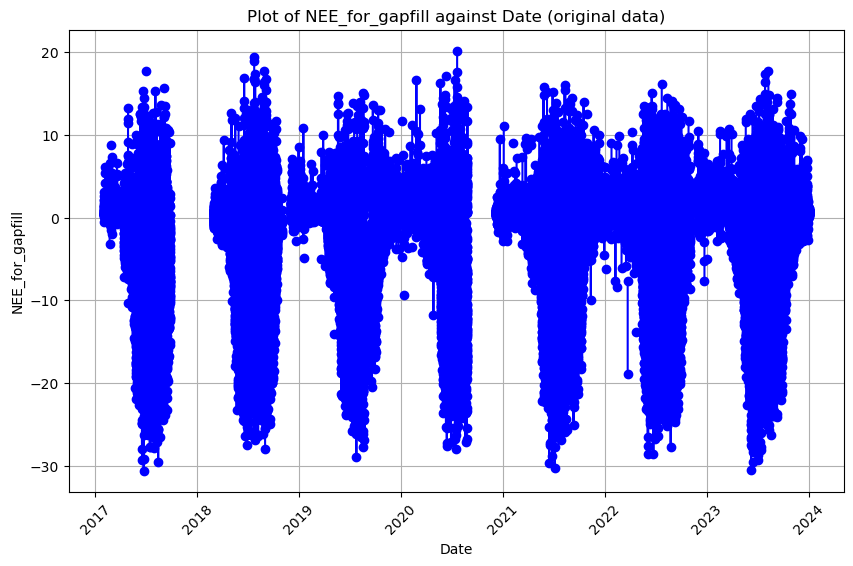

In [13]:
site_name = "BART_NEON"
file_name = f"data_for_XGB_{site_name}.csv"  

site_data, site_data_no_na = load_data(site_data_dir, file_name, y_col)

# 01 find the best hyperparameters

In [ ]:
# param_FC = find_hyperparameters(site_data_no_na, predictors, y_col, model_dir) 
# this line takes a long time to run (> 5 hours), please skip it and load the saved model to test the rest of the script

In [14]:
# load the model after hyperparameter tuning
model_path = (model_dir ) / "FC_XGB_model.pkl"
with open(model_path, 'rb') as f:
    reg = pkl.load(f)
reg = XGBRegressor(device='cpu')
reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

# 02 model performance

In [15]:
create_train_test_folds(site_data, site_data_dir, y_col) 
# I saved 10 fold train and test data under / data_train_test_dir, then read in the data in the check_model_performance, which is not very efficient

Train/test files saved in F:\NEON_gapfill\FC_data_train_test


In [16]:
check_model_performance(data_train_test_dir, predictors, y_col, learning_curve_dir, test_performance_dir, reg)

Processing Fold 1...
[14:37:30] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Saved learning curve for Fold 1
{'RMSE': 2.4746330890764847, 'R2': 0.8699570132996157, 'MAPE': 82.42902657583858}
Processing Fold 2...
[14:37:32] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Saved learning curve for Fold 2
{'RMSE': 2.555351907923781, 'R2': 0.8640382631521875, 'MAPE': 82.48512803085231}
Processing Fold 3...
[14:37:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Saved learning curve for Fold 3
{'RMSE': 2.569717989524336, 'R2': 0.8683271217286626, 'MAPE': 75.83425142988064}
Processin

# 03 do gapfill 

In [17]:
get_accurate_prediction(site_data, site_data_no_na, predictors, y_col, site_data_dir, reg)

[14:38:02] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Predictions saved to: F:\NEON_gapfill\FC_XGB_prediction.csv


,Year,Day,Hour,Date,Month,DOY,TIMESTAMP_END,GCC,EVI,Tair,...,DOY_sin,DOY_cos,NEE_for_gapfill,PPFD,H_for_gapfill,LE_for_gapfill,P_7day,P_30day,XGB_FC_fall,XGB_FC_f
0,2017,1,0.5,2017-01-01,1,1,201701010030,0.34364,0.215800,-4.892428,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.871892,0.871892
1,2017,1,1.0,2017-01-01,1,1,201701010100,0.34364,0.215800,-4.475620,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.871892,0.871892
2,2017,1,1.5,2017-01-01,1,1,201701010130,0.34364,0.215800,-4.684024,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.871892,0.871892
3,2017,1,2.0,2017-01-01,1,1,201701010200,0.34364,0.215800,-4.713796,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.871892,0.871892
4,2017,1,2.5,2017-01-01,1,1,201701010230,0.34364,0.215800,-4.753492,...,0.017166,0.999853,NaN,-2.8571,NaN,NaN,0.000,0.0,0.871892,0.871892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122673,2023,31,17.0,2023-12-31,12,365,202312311700,0.34500,0.242523,-4.352200,...,-0.017166,0.999853,NaN,0.6200,-17.674933,5.915219,18.611,232.3,0.841287,0.841287
122674,2023,31,17.5,2023-12-31,12,365,202312311730,0.34500,0.242523,-4.543100,...,-0.017166,0.999853,NaN,0.1400,-19.945106,1.918483,18.611,232.3,0.777217,0.777217
122675,2023,31,18.0,2023-12-31,12,365,202312311800,0.34500,0.242523,-4.665800,...,-0.017166,0.999853,NaN,0.1400,-24.592497,7.285188,18.611,232.3,0.777217,0.777217
122676,2023,31,18.5,2023-12-31,12,365,202312311830,0.34500,0.242523,-4.818400,...,-0.017166,0.999853,1.194168,0.1500,-44.558458,12.799249,18.611,232.3,0.878554,1.194168


# 04 feature importances

[14:38:12] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.



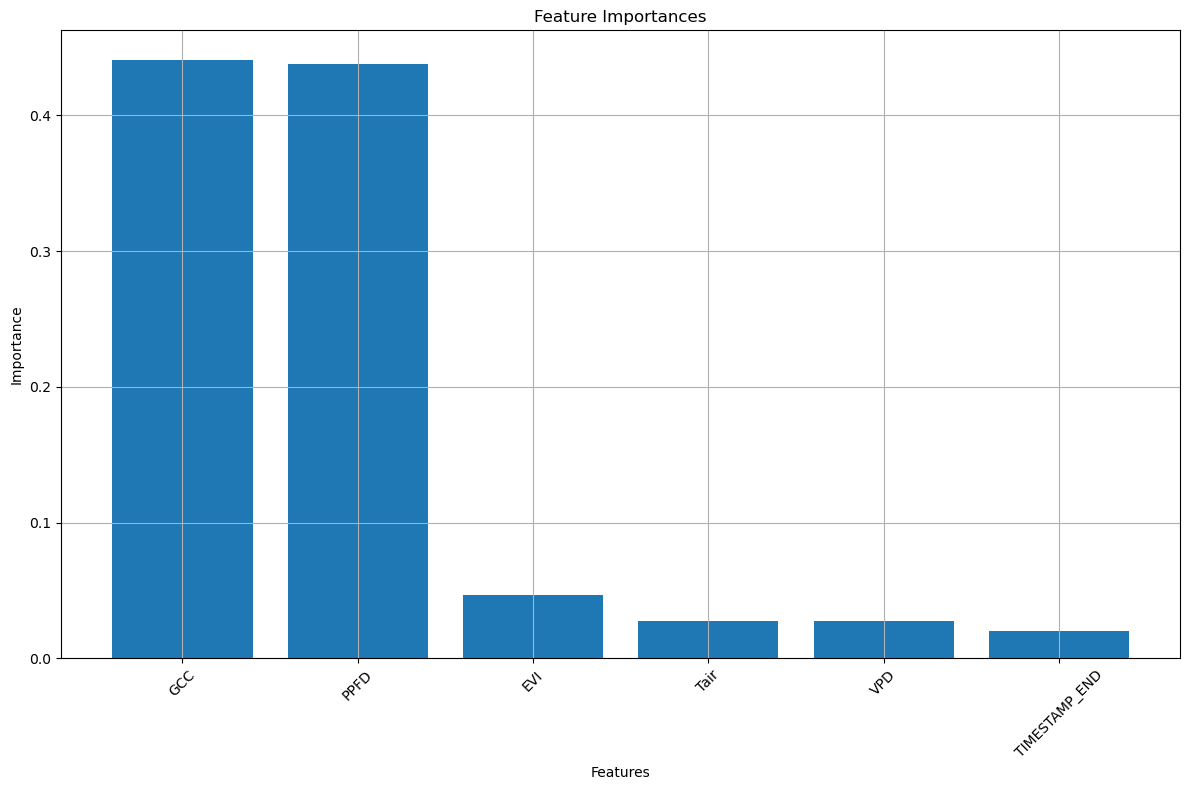

,Feature_Importances,predictors
1,0.440525,GCC
5,0.437640,PPFD
2,0.047012,EVI
3,0.027377,Tair
4,0.027291,VPD
0,0.020154,TIMESTAMP_END


In [18]:
feature_importance(site_data_no_na, predictors, y_col, site_data_dir, reg)

# 05 annual sums and monthly sums

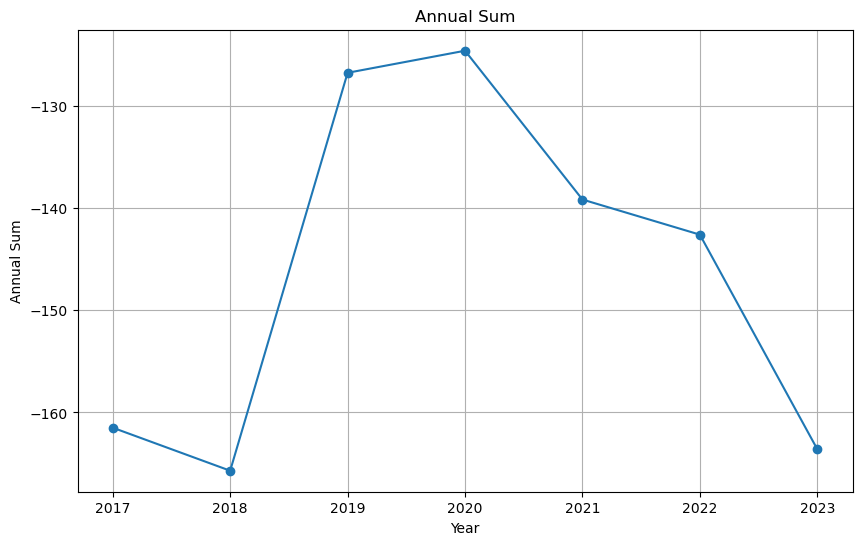

,Year,annual_sum
0,2017,-161.497959
1,2018,-165.708498
2,2019,-126.756605
3,2020,-124.596157
4,2021,-139.163420
5,2022,-142.601187
6,2023,-163.603832


In [19]:
data_prediction = pd.read_csv(site_data_dir/ "FC_XGB_prediction.csv")
cal_annual_sum(data_prediction, "XGB_FC_f", 2017, 2023, site_data_dir)

Check if you have 'Month' and 'Year' columns in input data!


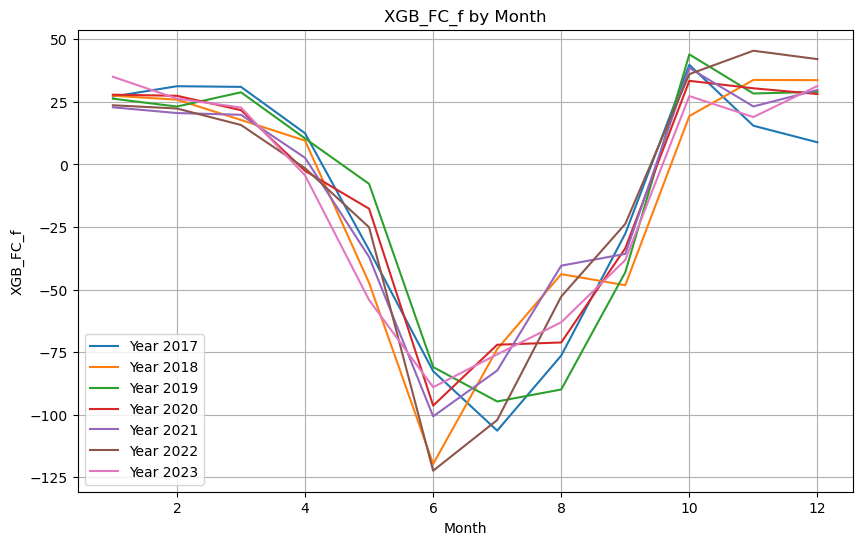

,Year,Month,monthly_sum
0,2017,1,27.105164
1,2017,2,31.240031
2,2017,3,30.979599
3,2017,4,12.438320
4,2017,5,-34.225867
...,...,...,...
79,2023,8,-63.092092
80,2023,9,-38.215303
81,2023,10,27.299337
82,2023,11,18.916490


In [20]:
cal_monthly_sum(data_prediction, "XGB_FC_f", 2017, 2023, site_data_dir)